#**Import Libraries**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px

from datetime import datetime
from sklearn.linear_model import LinearRegression

from statsmodels.stats.weightstats import ztest

#**Download file**

In [2]:
!gdown --id 1aEyJBEWsjWIjyFiJtF1oqNB1jxSRkAFk

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1aEyJBEWsjWIjyFiJtF1oqNB1jxSRkAFk
To: /content/us_health_insurance_cleaned.csv
100% 80.8k/80.8k [00:00<00:00, 3.53MB/s]


In [3]:
df = pd.read_csv('/content/us_health_insurance_cleaned.csv')
df['most_recent_insur_pur'] = pd.to_datetime(df['most_recent_insur_pur'])

#**5.1. Time series**

## Biểu đồ thể hiện sự thay đổi của khoản phí (charges) từ năm 2015 đến năm 2022

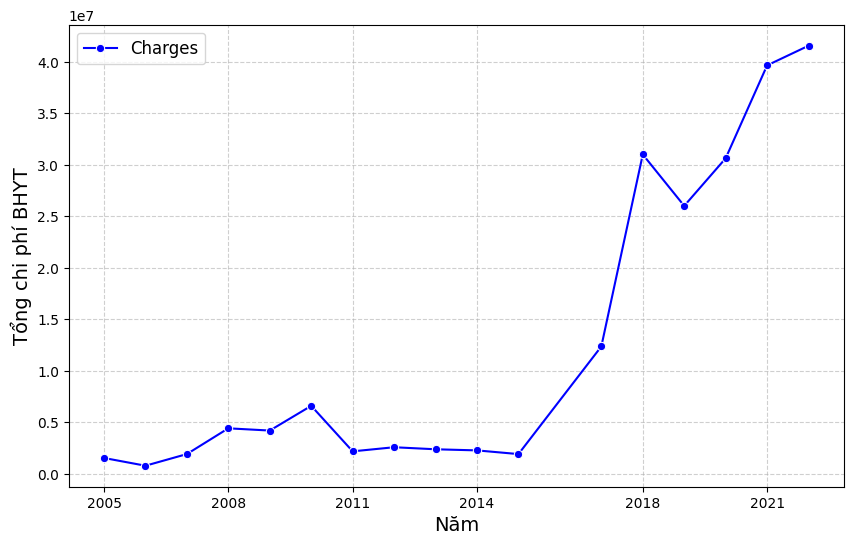

In [ ]:
df['year'] = df['most_recent_insur_pur'].dt.year
charges_each_year = df.groupby('year').agg({'charges' : 'sum'}).rename(columns={'charges' : 'total_charges_each_year'})

plt.figure(figsize=(10,6))
sns.lineplot(data=charges_each_year, x=charges_each_year.index, y='total_charges_each_year', marker='o', color='b', label='Charges')

# Đặt tiêu đề và nhãn cho trục x và y
plt.xlabel('Năm', fontsize=14)
plt.ylabel('Tổng chi phí BHYT', fontsize=14)
plt.xticks(charges_each_year.index.astype(int))
plt.xticks(charges_each_year.index[::3])

# Hiển thị chú thích
plt.legend(loc='upper left', fontsize=12)

# Hiển thị lưới đằng sau biểu đồ
plt.grid(axis='both', linestyle='--', alpha=0.6)

# Hiển thị biểu đồ
plt.show()

## Biểu đồ biểu diễn 5 tháng có tổng tiền bảo hiểm y tế mà khách hàng chi trả cao nhất.

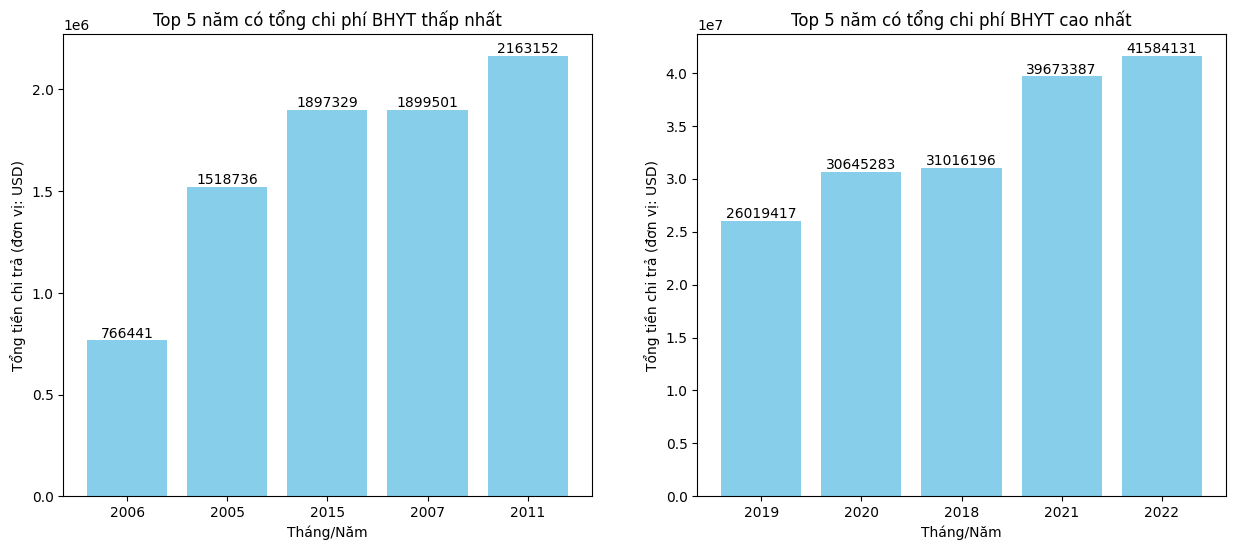

In [ ]:
# Xử lý dữ liệu
df['most_recent_insur_pur'] = pd.to_datetime(df['most_recent_insur_pur'])
df['year'] = df['most_recent_insur_pur'].dt.to_period('Y')

# Tính tổng tiền chi trả theo năm
yearly_charges = df.groupby('year')['charges'].sum().reset_index()

# Sắp xếp theo thứ tự năm
yearly_charges_sorted = yearly_charges.sort_values('charges')

# Tạo subplot với 1 hàng và 2 cột
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Biểu đồ cho top 5 năm có charges thấp nhất
bars_low = axs[0].bar(yearly_charges_sorted.head(5)['year'].dt.strftime('%Y'), yearly_charges_sorted.head(5)['charges'], color='skyblue')
axs[0].set_xlabel('Tháng/Năm')
axs[0].set_ylabel('Tổng tiền chi trả (đơn vị: USD)')
axs[0].set_title('Top 5 năm có tổng chi phí BHYT thấp nhất')

# Biểu đồ cho top 5 năm có charges cao nhất
bars_high = axs[1].bar(yearly_charges_sorted.tail(5)['year'].dt.strftime('%Y'), yearly_charges_sorted.tail(5)['charges'], color='skyblue')
axs[1].set_xlabel('Tháng/Năm')
axs[1].set_ylabel('Tổng tiền chi trả (đơn vị: USD)')
axs[1].set_title('Top 5 năm có tổng chi phí BHYT cao nhất')

# Thêm số trên đầu mỗi cột cho biểu đồ top 5 charges thấp nhất
for bar in bars_low:
    yval = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Thêm số trên đầu mỗi cột cho biểu đồ top 5 charges cao nhất
for bar in bars_high:
    yval = bar.get_height()
    axs[1].text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Hiển thị biểu đồ
plt.show()

## Biểu đồ biểu diễn 5 tháng có số lượng khách hàng đăng ký bảo hiểm nhiều nhất trong 3 năm: 2020, 2021, 2022.

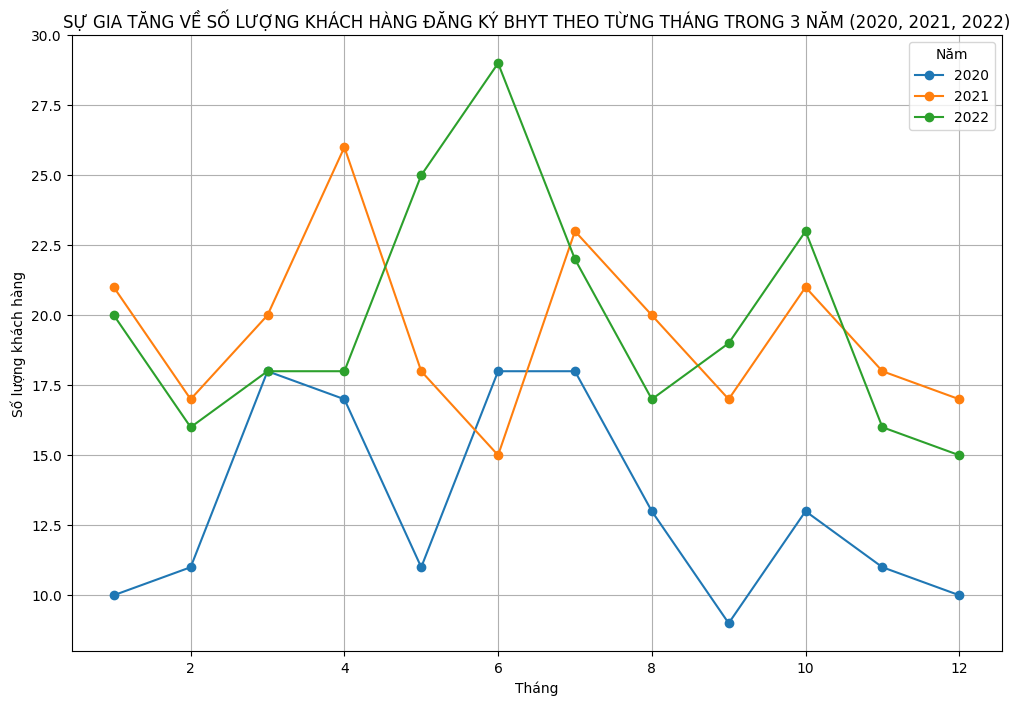

In [ ]:
# Xử lý dữ liệu
df['most_recent_insur_pur'] = pd.to_datetime(df['most_recent_insur_pur'], format='%m/%d/%Y')
df['Year'] = df['most_recent_insur_pur'].dt.year

# Tạo DataFrame mới theo năm
years = [2020, 2021, 2022]
df_by_year = {year: df[df['Year'] == year] for year in years}

# Vẽ biểu đồ line plot
plt.figure(figsize=(12, 8))

for year, data in df_by_year.items():
    monthly_counts = data['most_recent_insur_pur'].dt.month.value_counts().sort_index()
    plt.plot(monthly_counts.index, monthly_counts.values, label=str(year), marker='o', linestyle='-')

plt.title('SỰ GIA TĂNG VỀ SỐ LƯỢNG KHÁCH HÀNG ĐĂNG KÝ BHYT THEO TỪNG THÁNG TRONG 3 NĂM (2020, 2021, 2022)')
plt.xlabel('Tháng')
plt.ylabel('Số lượng khách hàng')
plt.legend(title='Năm')
plt.grid(True)
plt.show()

## Tổng chi phí chi trả cho BHYT của 3 nhóm độ tuổi trong năm 2020 và năm 2022.


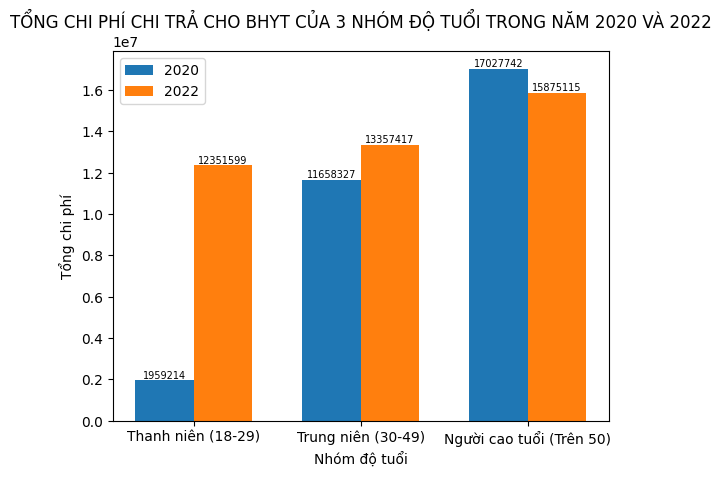

In [ ]:
# Bổ sung (cân nhắc do dài quá)
# Xử lý dữ liệu
df['most_recent_insur_pur'] = pd.to_datetime(df['most_recent_insur_pur'])

# Xác định nhóm độ tuổi
df['age_group'] = pd.cut(df['age'], bins=[0, 29, 49, float('inf')], labels=['Thanh niên (18-29)', 'Trung niên (30-49)', 'Người cao tuổi (Trên 50)'])

# Thiết lập dữ liệu cho các năm 2020 và 2022
df_2020 = df[df['most_recent_insur_pur'].dt.year == 2020]
df_2022 = df[df['most_recent_insur_pur'].dt.year == 2022]

total_charges_2020 = df_2020.groupby(['age_group'])['charges'].sum()
total_charges_2022 = df_2022.groupby(['age_group'])['charges'].sum()

# Vẽ biểu đồ Bar chart
fig, ax = plt.subplots()

bar_width = 0.35
bar_positions_2020 = range(len(total_charges_2020))
bar_positions_2022 = [pos + bar_width for pos in bar_positions_2020]

bars_2020 = ax.bar(bar_positions_2020, total_charges_2020, bar_width, label='2020')
bars_2022 = ax.bar(bar_positions_2022, total_charges_2022, bar_width, label='2022')

# Đặt tên cho trục và biểu đồ
ax.set_xlabel('Nhóm độ tuổi')
ax.set_ylabel('Tổng chi phí')
ax.set_title('TỔNG CHI PHÍ CHI TRẢ CHO BHYT CỦA 3 NHÓM ĐỘ TUỔI TRONG NĂM 2020 VÀ 2022')
ax.set_xticks([pos + bar_width / 2 for pos in bar_positions_2020])
ax.set_xticklabels(total_charges_2020.index)
ax.legend()

# Thêm chú thích (tổng chi phí) trên mỗi đầu cột
for bar, total_charge in zip(bars_2020, total_charges_2020):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{total_charge:.0f}',
            ha='center', va='bottom', fontsize=7)

for bar, total_charge in zip(bars_2022, total_charges_2022):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{total_charge:.0f}',
            ha='center', va='bottom', fontsize=7)

plt.show()

## Biểu đồ thể hiện sự gia tăng của số lượng khách hàng tham gia bảo hiểm từ năm 2015 đến 2022, và dự đoán xu hướng tăng trưởng đến năm 2050.

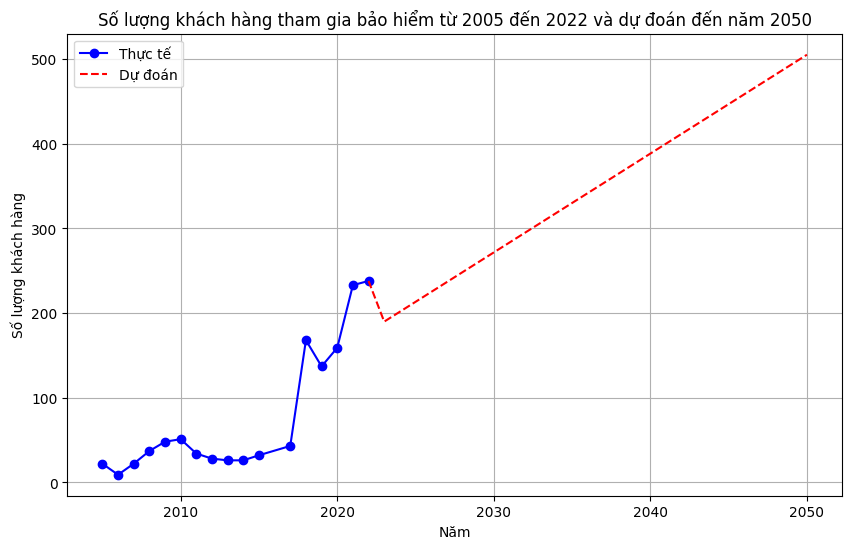

In [ ]:
# Chuyển đổi cột 'most_recent_insur_pur' sang định dạng datetime
df['most_recent_insur_pur'] = pd.to_datetime(df['most_recent_insur_pur'])

# Tạo một cột mới 'year' để lấy năm từ cột 'most_recent_insur_pur'
df['year'] = df['most_recent_insur_pur'].dt.year

# Tính tổng số lượng khách hàng theo năm
customer_count_by_year = df.groupby('year')['CusID'].count()

# Vẽ biểu đồ Line plot
plt.figure(figsize=(10, 6))
plt.plot(customer_count_by_year.index, customer_count_by_year.values, marker='o', linestyle='-', color='b', label='Dữ liệu thực tế')
plt.title('Số lượng khách hàng tham gia bảo hiểm từ 2005 đến 2022 và dự đoán đến năm 2050')
plt.xlabel('Năm')
plt.ylabel('Số lượng khách hàng')
plt.grid(True)

# Dự đoán xu hướng tăng trưởng sử dụng Linear Regression
X = np.array(customer_count_by_year.index).reshape(-1, 1)
y = customer_count_by_year.values
model = LinearRegression().fit(X, y)

# Tạo dãy số từ 2023 đến 2050 để dự đoán xu hướng tăng trưởng
future_years = np.arange(2023, 2051).reshape(-1, 1)
predicted_customer_count = model.predict(future_years)

# Vẽ đường dự đoán xu hướng tăng trưởng và nối liền với dữ liệu từ năm 2022
plt.plot(np.concatenate([X[X.flatten() >= 2022], future_years]), np.concatenate([y[X.flatten() >= 2022], predicted_customer_count]), linestyle='--', color='r')

plt.legend(['Thực tế', 'Dự đoán'])
plt.show()

#**5.2. Phân tích tổng hợp**

## Biểu đồ thể hiện tỷ lệ khách hàng vẫn đang đi làm khi tham gia bảo hiểm theo các thuộc tính phân loại: is_male, married, state

In [ ]:
# Vẽ Parallel Categories Plot nguyên bản
colorscale = ['blue', 'cyan']
fig = px.parallel_categories(df,
                              dimensions=['region', 'is_male', 'married', 'employ'],
                              color='employ', color_continuous_scale = colorscale,
                              labels={'is_male': 'Giới tính', 'married': 'Tình trạng hôn nhân', 'region': 'Khu vực', 'employ': 'Tình trạng việc làm'},
                              title='TỶ LỆ KHÁCH HÀNG VẪN ĐANG ĐI LÀM KHI THAM GIA BẢO HIỂM THEO CÁC THUỘC TÍNH PHÂN LOẠI',
                              width=1600,
                              )

# Thêm đường cong & tỷ lệ cho biểu đồ
fig.update_traces(line_shape='hspline', hoverinfo='count+probability')
fig.update_layout(coloraxis_colorbar = dict(tickvals = [0, 1],
                                            ticktext = ['0: Thất nghiệp', '1: Có việc làm'],
                                            tickmode = 'array'))

fig.show()

Z-statistic: 36.55338036574715
P-value: 1.5757431907735459e-292
Vì p_value < alpha => Có cơ sở để bác bỏ giả thuyết H0 => Có sự khác biệt về chi phí BHYT giữa nhóm có việc làm và không có việc làm.


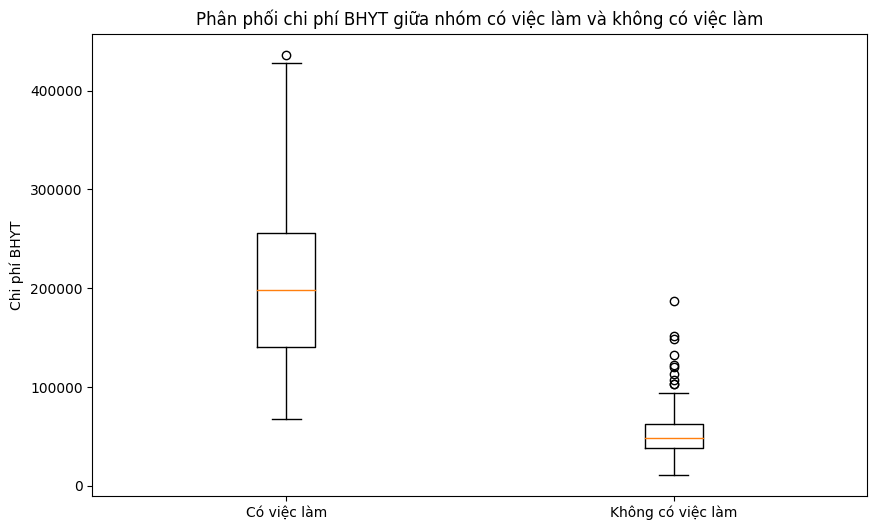

In [ ]:
# Tách dữ liệu thành hai nhóm: có việc làm và không có việc làm
employed_group = df[df['employ'] == 1]['charges']
unemployed_group = df[df['employ'] == 0]['charges']

# Thực hiện kiểm định z-test độc lập
z_statistic, p_value = ztest(employed_group, unemployed_group)

# In kết quả
print(f"Z-statistic: {z_statistic}")
print(f"P-value: {p_value}")

# Kiểm tra mức ý nghĩa (alpha = 0.05)
alpha = 0.05
if p_value < alpha:
    print("Vì p_value < alpha => Có cơ sở để bác bỏ giả thuyết H0 => Có sự khác biệt về chi phí BHYT giữa nhóm có việc làm và không có việc làm.")
else:
    print("Không có đủ bằng chứng để bác bỏ giả thuyết H0.")

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.boxplot([employed_group, unemployed_group], labels=['Có việc làm', 'Không có việc làm'])
plt.title('Phân phối chi phí BHYT giữa nhóm có việc làm và không có việc làm')
plt.ylabel('Chi phí BHYT')
plt.show()


#**5.3. Mật độ/ Khu vực**

## Biểu đồ thác nước (Waterfall Chart) cho khoản phí (charges) theo từng tiểu bang

In [5]:
charges_each_state = df.groupby('region').agg({'charges' : 'sum'}).rename(columns={'charges' : 'total_charges_each_state'})
top_charges_each_state = charges_each_state.reset_index()

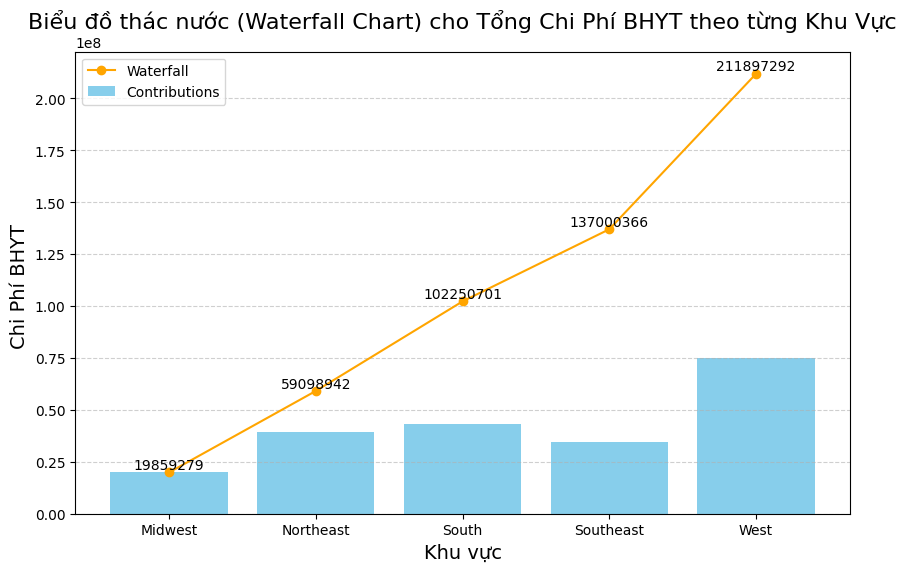

In [7]:
# Tạo biểu đồ thác nước
fig, ax = plt.subplots(figsize=(10, 6))
waterfall_values = top_charges_each_state['total_charges_each_state'].cumsum()

ax.bar(top_charges_each_state['region'], top_charges_each_state['total_charges_each_state'], color=[('skyblue' if c > 0 else 'r') for c in top_charges_each_state['total_charges_each_state']], label='Contributions')
ax.plot(top_charges_each_state['region'], waterfall_values, marker='o', linestyle='-', color='orange', label='Waterfall')

# Đặt tiêu đề và nhãn cho trục x và y
plt.title('Biểu đồ thác nước (Waterfall Chart) cho Tổng Chi Phí BHYT theo từng Khu Vực', fontsize=16)
plt.xlabel('Khu vực', fontsize=14)
plt.ylabel('Chi Phí BHYT ', fontsize=14)

# Thêm giá trị trên cột
for i, v in enumerate(waterfall_values):
    ax.text(i, v + 5, f'{v:.0f}', ha='center', va='bottom')

# Hiển thị chú thích
ax.legend()

# Hiển thị biểu đồ
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


## Biểu đồ hiển thị mối quan hệ giữa khu vực, chi phí y tế và số lượng trẻ em


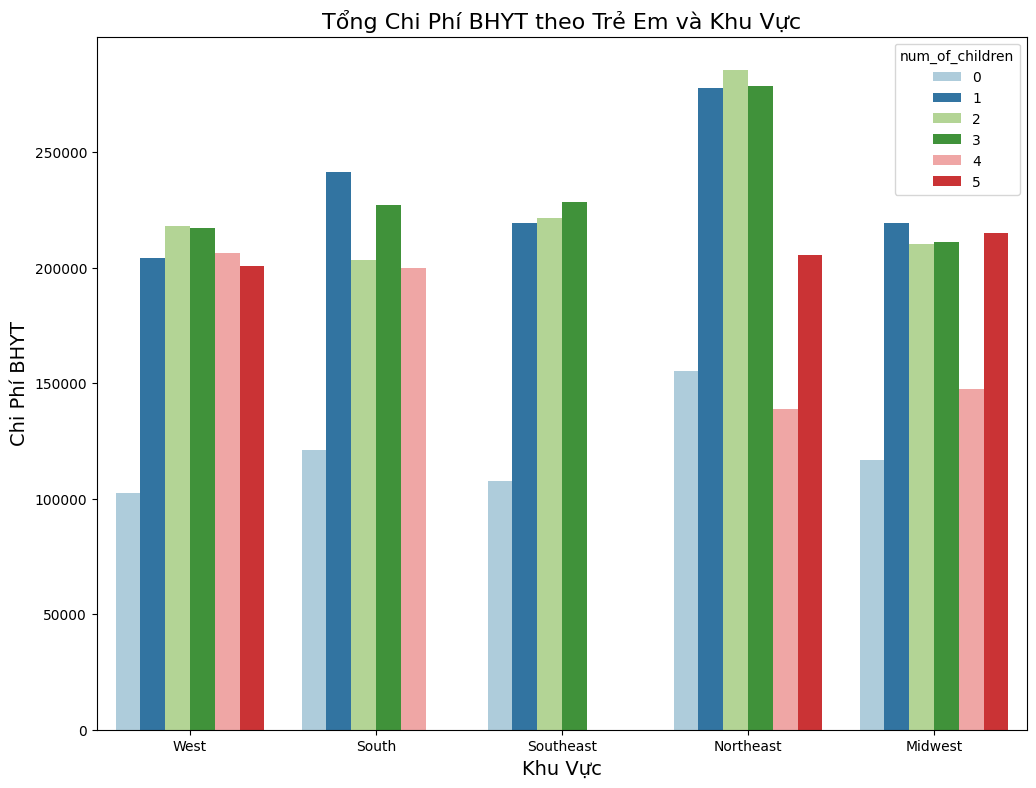

In [ ]:
# Thiết lập kích thước biểu đồ
plt.figure(figsize=(12, 9))

# Tạo biểu đồ cột
sns.barplot(data=df, x='region', y='charges', hue='num_of_children', palette='Paired', errorbar=None)
# Thay đổi tiêu đề của biểu đồ
plt.title('Tổng Chi Phí BHYT theo Trẻ Em và Khu Vực', fontsize=16)

# Định dạng trục x và trục y
plt.xlabel('Khu Vực', fontsize=14)
plt.ylabel('Chi Phí BHYT', fontsize=14)


plt.show()

##Biểu đồ Choropleth thể hiện mật độ sử dụng bảo hiểm tổng&trung bình theo từng bang

In [ ]:
##Tạo dict chứa code các state
df1 = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_us_ag_exports.csv')
list_index = list(df1['state'])
list_item = list(df1['code'])
state_codes = dict(zip(list_index, list_item))
print(state_codes)

{'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD', 'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'}


In [ ]:
# Có slider (theo từng năm)
from urllib.request import urlopen

# df['year'] = pd.DatetimeIndex(df['most_recent_insur_pur']).year
# df = df.sort_values(by='year', ascending=True)
# df['state_code']=df['state'].map(state_codes)
# fig = px.choropleth(df, locations='state_code', locationmode="USA-states", color=df['charges'],animation_frame = df['year'], scope='usa' )

# fig.show()

In [ ]:
# Tính tổng lượng đóng bảo hiểm theo từng bang và region
df_grouped = df.groupby(['state'])['charges'].sum().reset_index()
df_grouped['state_code']=df_grouped['state'].map(state_codes)
# Ko có slider (tổng thể)
fig = px.choropleth(df_grouped, locations='state_code', locationmode="USA-states", color=df_grouped['charges'], scope='usa', hover_name=df_grouped['state']  )
fig.update_layout(title_text="Biểu đồ thể hiện thể hiện mật độ sử dụng bảo hiểm theo từng bang")
fig.update_traces(marker_opacity=0.7)
fig.show()

In [ ]:
# Tính tổng lượng đóng bảo hiểm theo từng bang và region
df_grouped = df.groupby(['state'])['charges'].mean().reset_index()
df_grouped['state_code']=df_grouped['state'].map(state_codes)
# Ko có slider (tổng thể)
fig = px.choropleth(df_grouped, locations='state_code', locationmode="USA-states", color=df_grouped['charges'], color_continuous_scale='blues' , scope='usa', hover_name=df_grouped['state']  )
fig.update_layout(title_text="Biểu đồ thể hiện thể hiện mật độ sử dụng bảo hiểm trung bình theo từng bang")
fig.show()

In [ ]:
#print(df_grouped)

## 10 bang có số lượng khách hàng cao nhất.

In [ ]:
customer_each_state = df.groupby('state').agg({'age' : 'count'}).sort_values(by='age',ascending=False).rename(columns={'age' : 'The_Number_Of_Customer'})

In [ ]:
top_10_customer_each_state = customer_each_state.iloc[:10]

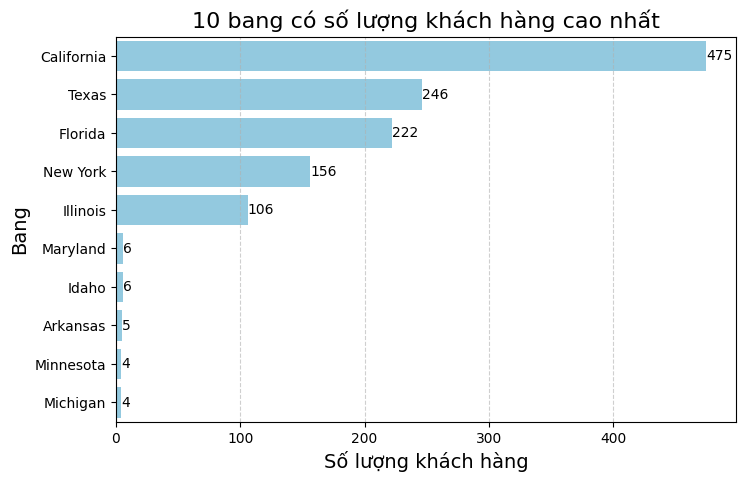

In [ ]:
# assuming 'The_Number_Of_Customer' is the column containing customer numbers
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=top_10_customer_each_state, y=top_10_customer_each_state.index, x='The_Number_Of_Customer', color='skyblue')

plt.title('10 bang có số lượng khách hàng cao nhất', fontsize=16)
plt.xlabel('Số lượng khách hàng', fontsize=14)
plt.ylabel('Bang', fontsize=14)

plt.grid(axis='x', linestyle='--', alpha=0.6)

# Annotating each bar with its value
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', (p.get_width() + 0.1, p.get_y() + p.get_height() / 2), ha='left', va='center')

plt.show()


##	Phân tích độ tuổi theo từng khu vực


In [ ]:
!pip install joypy
from joypy import joyplot

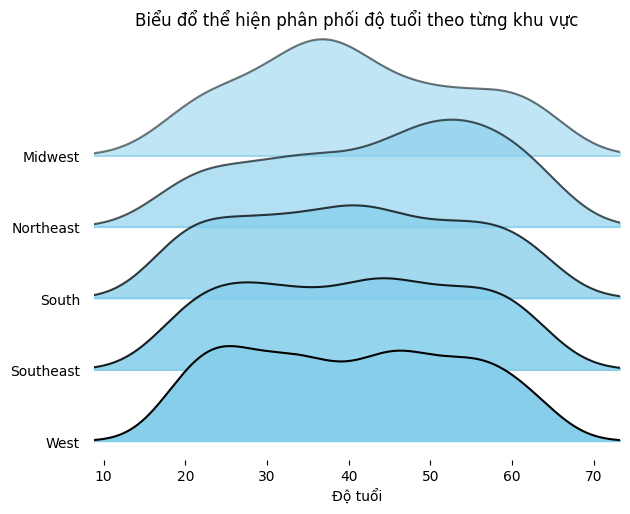

In [ ]:
joyplot(df, by = df['region'],column='age' , color='skyblue', fade = True)
plt.xlabel('Độ tuổi')
plt.ylabel('Khu vực')
plt.title('Biểu đổ thể hiện phân phối độ tuổi theo từng khu vực')
plt.show()

##	Phân tích độ tuổi trung bình theo từng tiểu bang

In [ ]:
# Tạo dataframe mới
df_new = df.groupby('state')['age'].mean().reset_index()
df_new = df_new.sort_values(by='age', ascending=True)

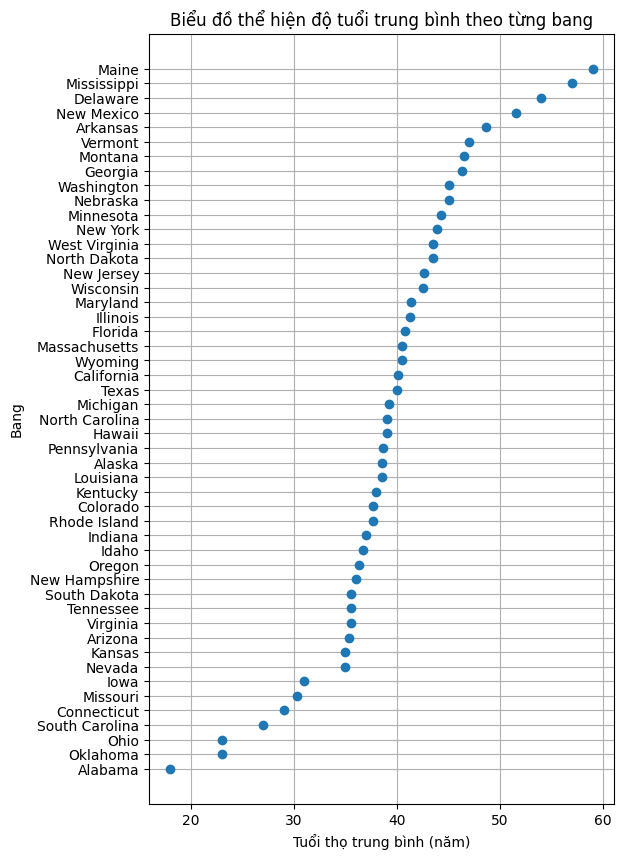

In [ ]:
#Vẽ dot plot
plt.figure(figsize=(6,10))
plt.plot(df_new['age'], df_new['state'], 'o')
plt.grid()
plt.ylabel('Bang')
plt.xlabel('Tuổi thọ trung bình (năm)')
plt.title('Biểu đồ thể hiện độ tuổi trung bình theo từng bang')
plt.show()

## Phân tích số tiền đóng bảo hiểm theo từng bang  trong 5 khu vực ở Hoa Kỳ

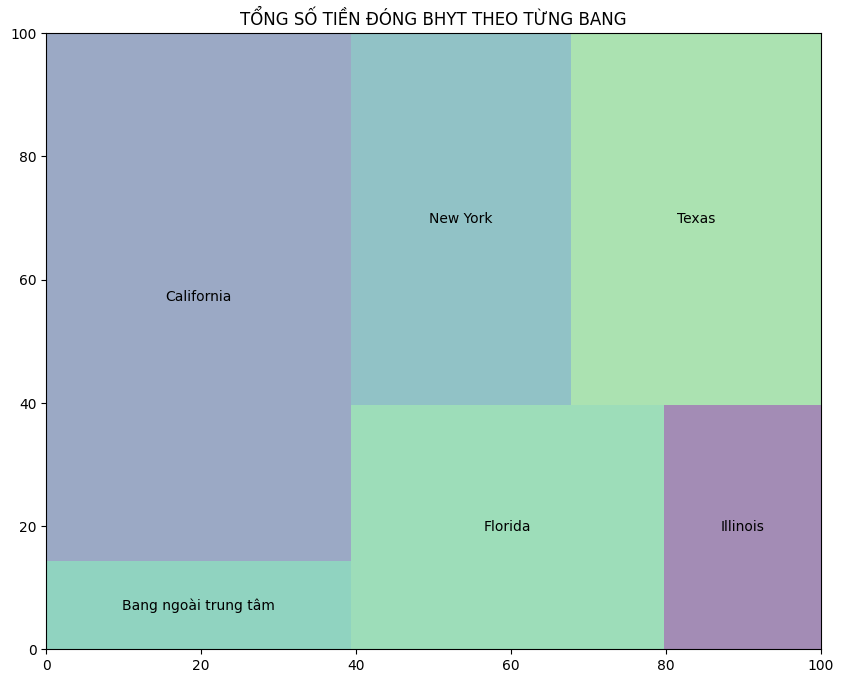

In [ ]:
!pip install squarify
import squarify
# Gom nhóm và tính tổng lượng đóng bảo hiểm theo bang
df_new = df.groupby('state')['charges'].sum().reset_index()

# Gom nhóm các bang ngoài trung tâm
central_states = ['California', 'Florida', 'Texas', 'Illinois', 'New York']
df_new['region_grouped'] = df_new['state'].apply(lambda x: 'Bang ngoài trung tâm' if x not in central_states else x)

# Tính tổng lượng đóng bảo hiểm theo nhóm
df_grouped = df_new.groupby('region_grouped')['charges'].sum().reset_index()

# Vẽ biểu đồ Mosaic plot
sizes = df_grouped['charges']
labels = df_grouped['region_grouped']

plt.figure(figsize=(10, 8))
squarify.plot(sizes=sizes, label=labels, alpha=.5)
plt.axis("on")
plt.title("TỔNG SỐ TIỀN ĐÓNG BHYT THEO TỪNG BANG")
plt.show()

In [ ]:
# Tính tổng lượng đóng bảo hiểm theo từng bang và region
df_grouped = df.groupby(['region', 'state'])['charges'].sum().reset_index()

# Vẽ biểu đồ treemap sử dụng plotly
fig = px.treemap(df_grouped, path=['region', 'state'], values='charges',
                 title="Tổng lượng đóng bảo hiểm theo khu vực và bang",
                 width=1000, height=600)

# Điều chỉnh cỡ chữ và vị trí của labels
fig.update_traces(
    textfont=dict(family="Arial", size=14),
    textposition='middle center',
    hovertemplate='<b>%{label}</b><br>Total Charges: $%{value:,.2f}',
    hoverlabel=dict(bgcolor='rgba(255, 255, 255, 0.4)')
)

# Hiển thị biểu đồ
fig.show()

#**5.4. Sức khỏe**

## Biểu đồ thể hiện mối quan hệ giữa tuổi, phí y tế và chỉ số khối cơ thể

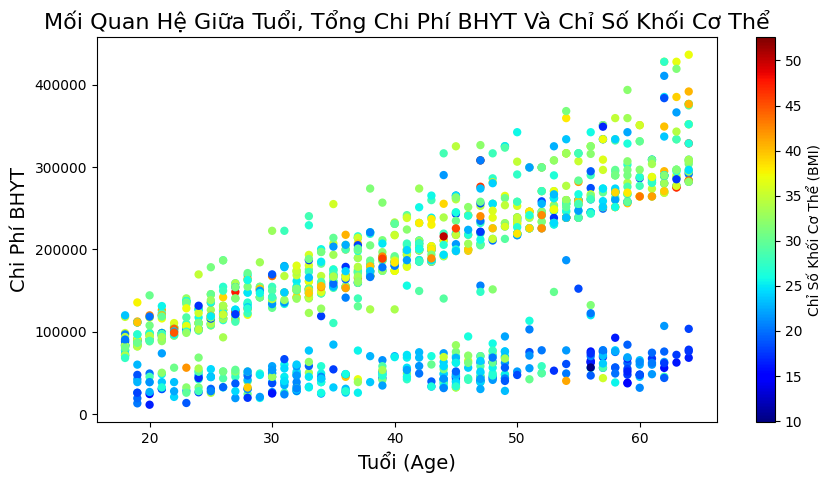

In [ ]:
# Tạo biểu đồ phân tán
plt.figure(figsize=(10, 5))
scatter = plt.scatter(x="age", y="charges", c='bmi', cmap=plt.get_cmap("jet"), data=df)

# Thêm colorbar và định dạng trục x, trục y
plt.colorbar(scatter, label='Chỉ Số Khối Cơ Thể (BMI)')
plt.xlabel('Tuổi (Age)', fontsize=14)
plt.ylabel('Chi Phí BHYT', fontsize=14)

# Thay đổi tiêu đề của biểu đồ
plt.title('Mối Quan Hệ Giữa Tuổi, Tổng Chi Phí BHYT Và Chỉ Số Khối Cơ Thể', fontsize=16)

# Hiển thị biểu đồ
plt.show()


In [ ]:
df.head()

,CusID,age,is_male,married,num_of_children,bmi,smoker,state,region,employ,most_recent_insur_pur,insur_renewals,charges,year,Year,age_group
0,CS619,64,0,1,2,47.600,0,California,West,1,2022-04-21,51,328644,2022,2022,Người cao tuổi (Trên 50)
1,CS146,64,1,0,0,17.320,1,West Virginia,South,0,2007-10-28,12,78030,2007,2007,Người cao tuổi (Trên 50)
2,CS224,64,1,0,0,16.400,1,Florida,Southeast,0,2009-04-04,10,68234,2009,2009,Người cao tuổi (Trên 50)
3,CS949,64,1,1,0,36.955,0,New York,Northeast,1,2018-01-22,51,436356,2018,2018,Người cao tuổi (Trên 50)
4,CS265,64,0,1,1,38.665,0,New York,Northeast,1,2019-11-10,44,376464,2019,2019,Người cao tuổi (Trên 50)


In [ ]:
df.groupby('smoker').agg({'charges' : 'sum', 'CusID' : 'count', 'charges' : 'mean'})

,charges,CusID
smoker,,
0,168799.781742,953
1,141753.055556,360


## Biểu đồ thể hiện sự phân phối của phí y tế (charges) dựa trên giới tính (nam và nữ) và việc hút thuốc hoặc không hút thuốc

<Figure size 1000x500 with 0 Axes>

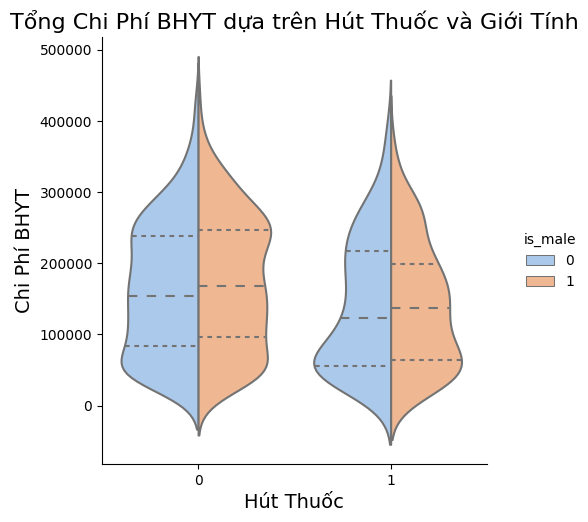

In [ ]:
# Tạo biểu đồ violin
plt.figure(figsize=(10,5))
sns.catplot(x="smoker", y="charges", hue="is_male",
            kind="violin", inner="quartiles", split=True,
            palette="pastel", data=df)

# Thay đổi tiêu đề của biểu đồ
plt.title('Tổng Chi Phí BHYT dựa trên Hút Thuốc và Giới Tính', fontsize=16)

# Định dạng trục x và trục y
plt.xlabel('Hút Thuốc', fontsize=14)
plt.ylabel('Chi Phí BHYT', fontsize=14)

# Hiển thị biểu đồ
plt.show();

##	Phân bố Dân số theo Nhóm Tuổi và Giới tính


In [ ]:
#set khung tuổi nam
age18_25_m = df.age[(df.age <= 25) & (df.age >= 18) & (df.is_male == 1)]
age26_30_m = df.age[(df.age <= 30) & (df.age >= 26) & (df.is_male == 1)]
age31_35_m = df.age[(df.age <= 35) & (df.age >= 31) & (df.is_male == 1)]
age36_40_m = df.age[(df.age <= 40) & (df.age >= 36) & (df.is_male == 1)]
age41_45_m = df.age[(df.age <= 45) & (df.age >= 41) & (df.is_male == 1)]
age46_50_m = df.age[(df.age <= 50) & (df.age >= 46) & (df.is_male == 1)]
age51_55_m = df.age[(df.age <= 55) & (df.age >= 51) & (df.is_male == 1)]
age56_60_m = df.age[(df.age <= 60) & (df.age >= 56) & (df.is_male == 1)]
age60above_m = df.age[(df.age >= 61) & (df.is_male == 1)]

# #set khung tuổi nữ
age18_25_f = df.age[(df.age <= 25) & (df.age >= 18) & (df.is_male == 0)]
age26_30_f = df.age[(df.age <= 30) & (df.age >= 26) & (df.is_male == 0)]
age31_35_f = df.age[(df.age <= 35) & (df.age >= 31) & (df.is_male == 0)]
age36_40_f = df.age[(df.age <= 40) & (df.age >= 36) & (df.is_male == 0)]
age41_45_f = df.age[(df.age <= 45) & (df.age >= 41) & (df.is_male == 0)]
age46_50_f = df.age[(df.age <= 50) & (df.age >= 46) & (df.is_male == 0)]
age51_55_f = df.age[(df.age <= 55) & (df.age >= 51) & (df.is_male == 0)]
age56_60_f = df.age[(df.age <= 60) & (df.age >= 56) & (df.is_male == 0)]
age60above_f = df.age[(df.age >= 61) & (df.is_male == 0)]

khungtuoi = ["18-25","26-30","31-35","36-40","41-45","46-50","51-55","56-60","60+"]
nam = [len(age18_25_m.values),len(age26_30_m.values),len(age31_35_m.values),len(age36_40_m.values),len(age41_45_m.values)
,len(age46_50_m.values),len(age51_55_m.values),len(age56_60_m.values),len(age60above_m.values)]
nu = [len(age18_25_f.values),len(age26_30_f.values),len(age31_35_f.values),len(age36_40_f.values),len(age41_45_f.values)
,len(age46_50_f.values),len(age51_55_f.values),len(age56_60_f.values),len(age60above_f.values)]
pp = pd.DataFrame({'khungtuoi': khungtuoi, 'nam': nam, 'nu': nu})

y=pp['khungtuoi']
x1=pp['nam']
x2=pp['nu']*-1
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Bar(
    y = y,
    x= x1,
    name='Nam',
    orientation='h'
))
fig.add_trace(go.Bar(
    y = y,
    x= x2,
    name='Nữ',
    orientation='h',
))
fig.update_layout(
    template='plotly_white',
    title='Biểu đồ thể hiện tháp dân số',
    title_font_size=24,
    barmode='relative',
    bargap=0.0,
    bargroupgap=0,
    xaxis=dict(
        tickvals=[-150,-100,-50,0,50,100,150],
        ticktext=['150','100','50','0','50','100','150']
    )
)

